<a href="https://colab.research.google.com/github/devdandekar24/nifty-price-predictor-lstm-/blob/main/Walk_Forward_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
import math
import tensorflow as tf


In [ ]:
# --- Step 1: Load and Prepare Data ---
index_data = yf.download("^NSEI", start="2015-01-01", end="2024-12-31")
index_data['MA10'] = index_data['Close'].rolling(window=10).mean()
index_data['MA20'] = index_data['Close'].rolling(window=20).mean()
index_data['Return'] = index_data['Close'].pct_change()
index_data.dropna(inplace=True)

/tmp/ipython-input-3-1402103446.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  index_data = yf.download("^NSEI", start="2015-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


In [ ]:
# --- Reduced Set of Features ---
features = ['Close', 'MA10', 'MA20', 'Return']

In [ ]:
# Scaling
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(index_data[features])
y_scaled = target_scaler.fit_transform(index_data[['Close']])

In [ ]:
import joblib

# Save both scalers
joblib.dump(feature_scaler, "walk_forward_feature_scaler.pkl")
joblib.dump(target_scaler, "walk_forward_target_scaler.pkl")

['walk_forward_target_scaler.pkl']

In [ ]:
# --- Step 2: Walk-Forward Analysis for Jan 2024 - June 2025 ---
future_data = yf.download("^NSEI", start="2024-01-01", end="2025-06-30")
future_data['MA10'] = future_data['Close'].rolling(window=10).mean()
future_data['MA20'] = future_data['Close'].rolling(window=20).mean()
future_data['Return'] = future_data['Close'].pct_change()
future_data.dropna(inplace=True)

X_future_scaled = feature_scaler.transform(future_data[features])

/tmp/ipython-input-6-2924123295.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  future_data = yf.download("^NSEI", start="2024-01-01", end="2025-06-30")
[*********************100%***********************]  1 of 1 completed


In [ ]:
# --- Build model once ---
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(60, X_scaled.shape[1])))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# --- Walk-Forward Loop ---
time_step = 60
future_preds = []
last_train_X = X_scaled.copy()
last_train_y = y_scaled.copy()

In [ ]:
for i in range(len(X_future_scaled)):
    # Train model on current history
    X_seq, y_seq = [], []
    for j in range(time_step, len(last_train_X)):
        X_seq.append(last_train_X[j - time_step:j])
        y_seq.append(last_train_y[j])
    X_seq, y_seq = np.array(X_seq), np.array(y_seq)

    model.fit(X_seq, y_seq, epochs=5, batch_size=32, verbose=0)

    # Predict next day
    last_seq = last_train_X[-time_step:]
    next_input = X_future_scaled[i].reshape(1, 1, -1)
    combined_input = np.vstack([last_seq[1:], next_input.squeeze()])
    pred = model.predict(combined_input.reshape(1, time_step, X_scaled.shape[1]), verbose=0)
    future_preds.append(pred[0, 0])

    # Append this new day to history (simulate walk-forward)
    last_train_X = np.vstack([last_train_X, X_future_scaled[i]])
    last_train_y = np.vstack([last_train_y, pred])

In [ ]:
# ✅ Save the final model after walk-forward training
model.save("walk_forward_lstm_model.keras")  # saves the entire model (architecture + weights)
print("✅ Walk-forward model saved as walk_forward_lstm_model.h5")


✅ Walk-forward model saved as walk_forward_lstm_model.h5


In [ ]:
# --- Step 3: Inverse transform predictions ---
future_pred_actual = target_scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))


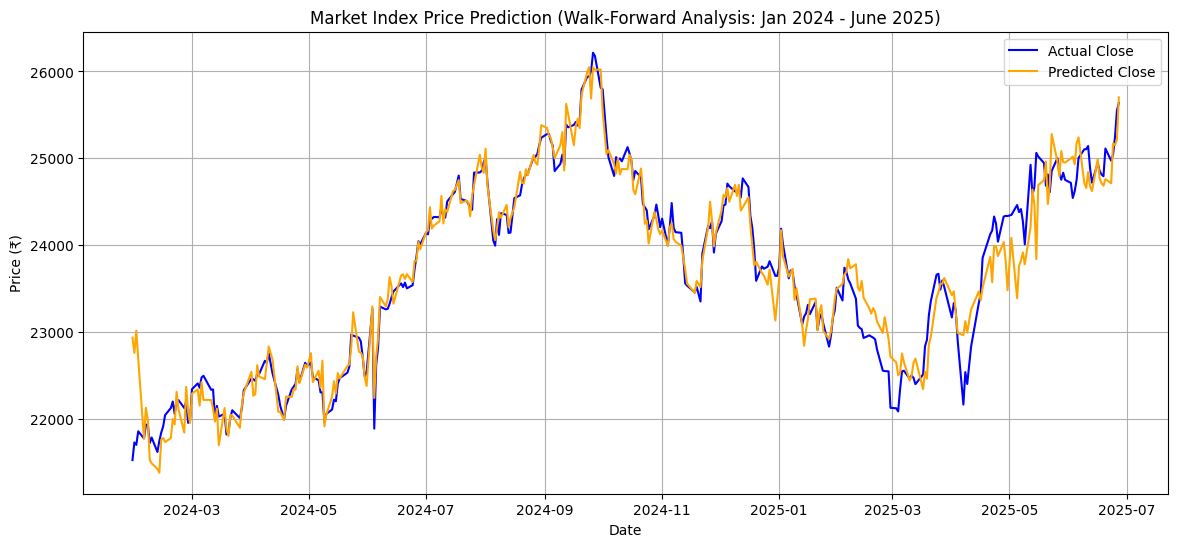

In [ ]:
# --- Step 4: Plotting ---
future_data = future_data.iloc[-len(future_pred_actual):].copy()
future_data['Predicted_Close'] = future_pred_actual

plt.figure(figsize=(14,6))
plt.plot(future_data.index, future_data['Close'], label="Actual Close", color="blue")
plt.plot(future_data.index, future_data['Predicted_Close'], label="Predicted Close", color="orange")
plt.title("Market Index Price Prediction (Walk-Forward Analysis: Jan 2024 - June 2025)")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# --- Step 5: Evaluate ---
rmse = math.sqrt(mean_squared_error(future_data['Close'], future_data['Predicted_Close']))
r2 = r2_score(future_data['Close'], future_data['Predicted_Close'])
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

RMSE: 265.39
R² Score: 0.9439


### lets try our model on new data

In [ ]:
import pickle
from tensorflow.keras.models import load_model


# 📁 Load Saved Scalers
feature_scaler = joblib.load("walk_forward_feature_scaler.pkl")
target_scaler = joblib.load("walk_forward_target_scaler.pkl")

# 📦 Load Saved LSTM Model
model = load_model("walk_forward_lstm_model.keras")

In [ ]:
# 📅 Fetch Future Data
future_data = yf.download("^NSEI", start="2025-01-01", end="2025-06-30")

# 🧠 Feature Engineering (MUST match training logic)
future_data['MA10'] = future_data['Close'].rolling(window=10).mean()
future_data['MA20'] = future_data['Close'].rolling(window=20).mean()
future_data['Return'] = future_data['Close'].pct_change()
future_data.dropna(inplace=True)

/tmp/ipython-input-19-1777542221.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  future_data = yf.download("^NSEI", start="2025-01-01", end="2025-06-30")
[*********************100%***********************]  1 of 1 completed


In [ ]:
# 🎯 Features used during training
features = ['Close', 'MA10', 'MA20', 'Return']
X_future_scaled = feature_scaler.transform(future_data[features])

In [ ]:
time_step = 60
X_seq = []

# use first 60 rows of `X_future_scaled` as base
for i in range(time_step, len(X_future_scaled)):
    X_seq.append(X_future_scaled[i - time_step:i])

X_seq = np.array(X_seq)


In [ ]:
# 📈 Predict
predictions_scaled = model.predict(X_seq, verbose=0)
predictions_actual = target_scaler.inverse_transform(predictions_scaled)

In [ ]:
# Match future_data size to predicted output (skip first 60)
plot_df = future_data.iloc[time_step:].copy()
plot_df['Predicted_Close'] = predictions_actual.flatten()

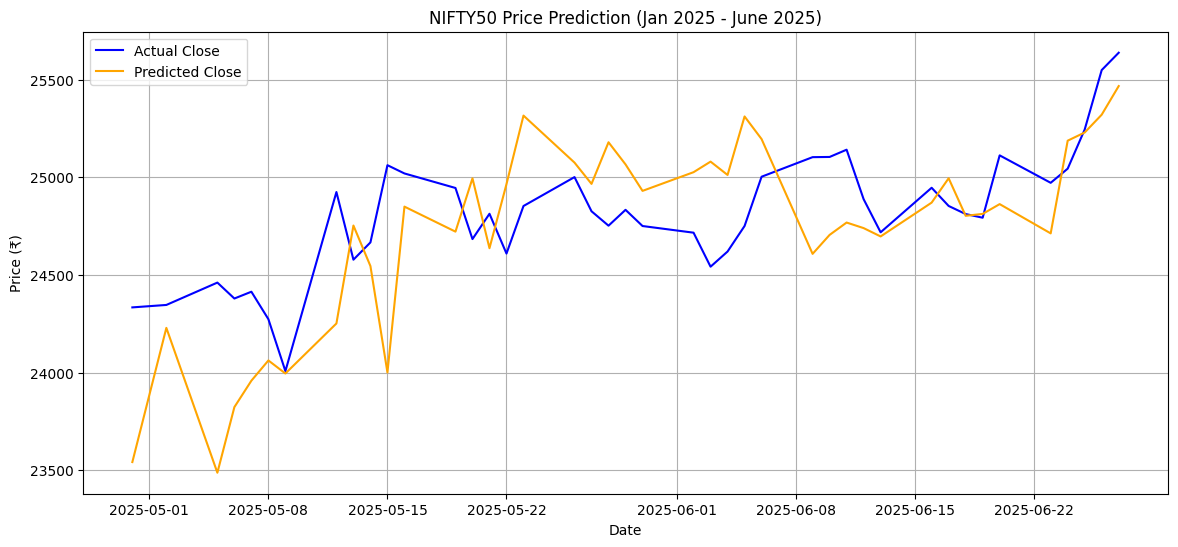

In [ ]:
# 📊 Plotting
plt.figure(figsize=(14,6))
plt.plot(plot_df.index, plot_df['Close'], label="Actual Close", color="blue")
plt.plot(plot_df.index, plot_df['Predicted_Close'], label="Predicted Close", color="orange")
plt.title("NIFTY50 Price Prediction (Jan 2025 - June 2025)")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.legend()
plt.grid(True)
plt.show()